In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

PRICE_DEC = 1
SIZE_DEC = 3
TEST_FRAC = 0.15

PERIODS = {
    'long': 90,
    'short': 10
}

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)

In [19]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))

def round_pred(y_pred, minstep = 0.5):
    return np.round(y_pred / minstep) * minstep

In [3]:
df = pd.read_csv('../../bars/bitmex-XBTUSD-1min.csv', parse_dates=['time'])
df.sort_values('time', ignore_index=True, inplace=True)
df.drop_duplicates(subset='time', ignore_index=True, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567865 entries, 0 to 567864
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        567865 non-null  datetime64[ns]
 1   open        567865 non-null  float64       
 2   high        567865 non-null  float64       
 3   low         567865 non-null  float64       
 4   close       567865 non-null  float64       
 5   avg         567865 non-null  float64       
 6   wavg        567865 non-null  float64       
 7   median      567865 non-null  float64       
 8   sum_vol     567865 non-null  int64         
 9   up_sum_vol  567865 non-null  int64         
 10  md_sum_vol  567865 non-null  int64         
 11  lo_sum_vol  567865 non-null  int64         
 12  net_vol     567865 non-null  int64         
 13  up_net_vol  567865 non-null  int64         
 14  md_net_vol  567865 non-null  int64         
 15  lo_net_vol  567865 non-null  int64         
 16  cn

Пропусков в самих данных также нет. 
Имеем дело со следующими столбцами:

| наименование | тип | описание |
|--------------|-------|--------|
|`time`        | datetime   | время начала периода (бара) |
|`open`        | float      | цена первой сделки периода   |    
|`high`        | float      | максимальная цена сделки периода |
|`low`         | float      | минимальная цена сделки периода   |    
|`close`       | float      | цена последней сделки периода |
|`avg`         | float      | средняя цена сделок периода |
|`wavg`        | float      | средневзвешенная по объему цена сделок периода |
|`median`      | float      | медиана цен сделок периода |
|`sum_vol`     | float      | сумма объемов сделок периода |
|`up_sum_vol`  | float      | сумма объемов сделок в промежутке цен от `high` до `max(open, close)`      |
|`md_sum_vol`  | float      | сумма объемов сделок в промежутке цен от `open` до `close`         |
|`lo_sum_vol`  | float      | сумма объемов сделок в промежутке цен от `low` до `min(open, close)` |
|`net_vol`     | float      | нетто-объем сделок периода (сумма объемов покупок минус сумма объемов продаж) |
|`up_net_vol`  | float      | нетто-объемо сделок в промежутке цен от `high` до `max(open, close)`        |
|`md_net_vol`  | float      | нетто-объем сделок в промежутке цен от `open` до `close`     |
|`lo_net_vol`  | float      | нетто-объемо сделок в промежутке цен от `low` до `min(open, close)`   |      
|`cnt`         | int        | количество сделок за период|
|`hbl`         | boolean    | цена `high` была достигнута раньше, чем цена `low`, 

Важный нюанс - perpetual фьючерсы `XBTUSD` и `ETHUSD` на бирже `Bitmex` являются **инверсными**, т.е. единица лота в них не сама криптовалюта, а доллар, а PnL, наоборот, рассчитывается и начисляется в криптовалюте. Это стандартная практика для криптовалютных бирж, которые не могут рассчитывать и начислять PnL в фиате или аналогичных фиату стебл-коинах. В случае `ETHUSD` все еще сложнее, ведь его лот привязан к долларовому выражению `BTC`. Поэтому пока не будем трогать `ETHUSD`, но для `XBTUSD` лоты пересчитаем в единицы криптовалюты, чтобы было: 
* единообразно по всем биржам в данном проекте
* проще для рассчетов PnL в моделях
* проще для восприятия

In [5]:
for col in df.columns:
    if col[-4:] == '_vol':
        df[col] = np.round(df[col] / df.close, SIZE_DEC)

In [6]:
df.sample(5)

,time,open,high,low,close,avg,wavg,median,sum_vol,up_sum_vol,md_sum_vol,lo_sum_vol,net_vol,up_net_vol,md_net_vol,lo_net_vol,cnt,hbl
393138,2021-10-01 09:49:00,44876.5,44908.5,44869.0,44900.0,44885.6,44879.5,44883.00,9.022,0.203,6.526,2.294,2.359,0.145,1.915,0.298,57,False
484390,2021-12-03 21:36:00,53815.0,53881.5,53814.5,53871.5,53845.7,53850.2,53848.75,3.226,0.876,2.341,0.009,1.151,-0.843,2.003,-0.009,108,False
106873,2021-03-16 05:18:00,54304.0,54326.5,54261.5,54294.0,54296.5,54290.8,54294.25,17.359,3.093,5.203,9.063,-0.185,-1.585,-2.916,4.316,188,True
90505,2021-03-04 20:26:00,47814.5,47840.5,47784.0,47835.5,47815.8,47815.5,47814.75,17.455,4.515,3.488,9.451,7.067,3.287,1.853,1.928,214,False
385997,2021-09-26 10:37:00,42925.0,43000.0,42925.0,43000.0,42979.4,42980.5,42988.00,20.516,0.000,20.516,0.000,4.181,0.000,4.181,0.000,149,False


In [7]:
model = pm.auto_arima(df.close, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,              # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6176069.877, Time=13.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6176875.343, Time=3.95 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6176210.133, Time=4.70 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6176183.456, Time=9.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6176873.388, Time=2.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6175921.820, Time=16.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6175981.393, Time=6.38 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6175942.338, Time=30.86 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6175923.331, Time=20.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6175888.998, Time=71.87 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6175994.928, Time=11.92 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6175884.407, Time=25.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6175937.798, Time=15.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6175888.42

In [9]:
TEST_SIZE = int(TEST_FRAC * len(df.close))
TRAIN_SIZE = len(df.close) - TEST_SIZE
df_train = df.close[:TRAIN_SIZE]
df_test = df.close[TRAIN_SIZE:]
model = ARIMA(df_train, order=(1,1,3))

In [10]:
ers = model.fit()
y_pred = ers.extend(df_test).predict()

In [11]:
y_pred = round_pred(y_pred)
mape(df_test, y_pred) * 100

0.0626202086211845

<AxesSubplot:xlabel='time', ylabel='close'>

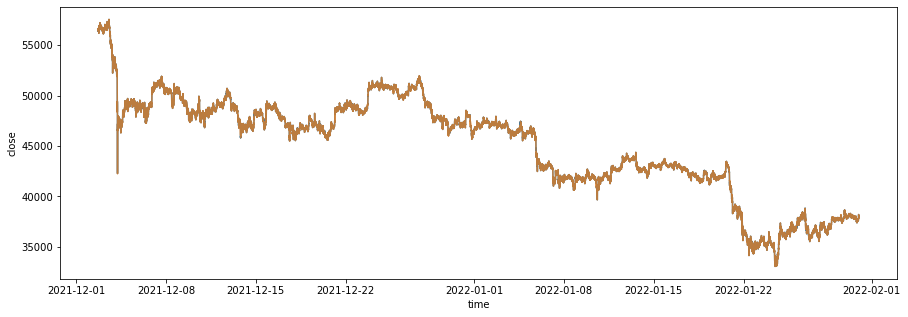

In [12]:
sns.lineplot(y=df_test, x=df.time[TRAIN_SIZE:])
sns.lineplot(y=y_pred, x=df.time[TRAIN_SIZE:], alpha=0.7)

<AxesSubplot:>

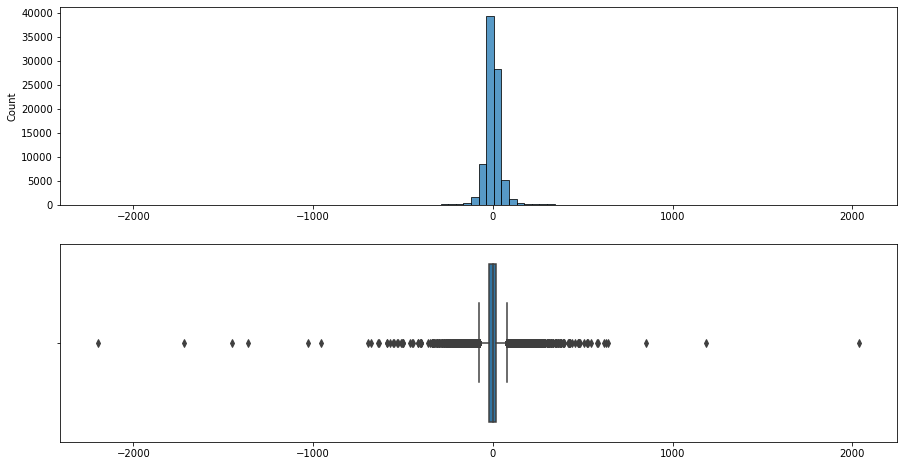

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(15,8))
sns.histplot(ax=ax[0],data=(df_test-y_pred), bins=100)
sns.boxplot(ax=ax[1], x=(df_test-y_pred))

In [15]:
cnt_up = 0
cnt_down = 0

def count_up_bars(x):
    global cnt_up
    cnt_up = (cnt_up + 1) if x > 0 else 0
    return cnt_up


def count_down_bars(x):
    global cnt_down
    cnt_down = (cnt_down + 1) if x < 0 else 0
    return cnt_down

In [16]:
prev_close = df.close.shift(1)
diff_close = df.close.diff()
df['up_in_row'] = diff_close.apply(count_up_bars)
df['down_in_row'] = diff_close.apply(count_down_bars)
df['TR'] = np.maximum(df.high, prev_close) - np.minimum(df.low, prev_close)

In [17]:
for key in PERIODS.keys():
    roll = df.rolling(PERIODS[key], min_periods=1)
    df[f'avg_{key}'] = roll.close.mean()
    df[f'std_{key}'] = roll.close.std()
    df[f'ATR_{key}'] = roll.TR.mean()
    df[f'high_{key}'] = roll.high.max()
    df[f'low_{key}'] = roll.low.min()
    df[f'sum_vol_{key}'] = roll.sum_vol.sum()
    df[f'net_vol_{key}'] = roll.net_vol.sum()

In [18]:
df.head(5)

,time,open,high,low,close,avg,wavg,median,sum_vol,up_sum_vol,...,low_long,sum_vol_long,net_vol_long,avg_short,std_short,ATR_short,high_short,low_short,sum_vol_short,net_vol_short
0,2021-01-01 00:00:00,28951.0,29004.0,28950.5,29004.0,28970.2,28978.9,28971.0,34.307,0.000,...,28950.5,34.307,23.374,29004.000,NaN,NaN,29004.0,28950.5,34.307,23.374
1,2021-01-01 00:01:00,29004.0,29050.0,29003.5,29043.5,29032.4,29034.1,29037.5,114.616,33.262,...,28950.5,148.923,105.040,29023.750,27.930718,46.500000,29050.0,28950.5,148.923,105.040
2,2021-01-01 00:02:00,29043.5,29044.0,29016.5,29017.0,29032.4,29033.4,29033.5,42.060,0.178,...,28950.5,190.983,77.923,29021.500,20.130822,37.000000,29050.0,28950.5,190.983,77.923
3,2021-01-01 00:03:00,29016.5,29026.0,29000.0,29016.0,29014.4,29014.3,29016.0,23.823,8.347,...,28950.5,214.806,82.767,29020.125,16.665208,33.333333,29050.0,28950.5,214.806,82.767
4,2021-01-01 00:04:00,29016.0,29016.5,29015.0,29015.0,29016.0,29016.0,29016.0,15.981,0.185,...,28950.5,230.787,67.159,29019.100,14.613350,25.375000,29050.0,28950.5,230.787,67.159
